https://www.kaggle.com/competitions/oxford-102-flower-pytorch

In [1]:
import torch
import torchvision
import json

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

print(torch.__version__)
print(torchvision.__version__)

2.3.0.dev20240120+cu121
0.18.0.dev20240120+cu121


In [2]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import glob
import numpy as np

from sklearn.model_selection import train_test_split
from pathlib import Path

In [3]:
# clear cuda
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# config
SEED = 42
BATCH_SIZE = 3
EPOCHS = 10
SAMPLE = 25

In [5]:
### import custom scripts
from scripts import engine_classification, custom_dataset

In [6]:
# root path
root_path = Path(os.getcwd())
print(root_path)

# directories
train_dir = root_path / "dataset_subset" / "train"
val_dir = root_path / "dataset_subset" / "val"
test_dir = root_path / "dataset" / "test/test"

/mnt/DiscoD/00_Learning/00_ArtificialIntelligence/AI_Aplications/05_Oxford_flowers


In [7]:
classes_all_num = os.listdir(root_path / "dataset/train")
len(classes_all_num)

102

In [8]:
# Opening JSON file
f = open('dataset/cat_to_name.json')
# json to dictionary
classes_name = json.load(f)
# Closing file
f.close()

In [9]:
len(classes_name)

102

In [10]:
print(classes_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [11]:
# Set the manual seeds
random.seed(SEED)

classes_sample_num = random.sample(range(1, len(classes_name)), SAMPLE)
classes_sample_num.sort()
classes_sample_num = list(set(classes_sample_num))
print(classes_sample_num)

[4, 5, 12, 14, 15, 18, 26, 28, 29, 30, 32, 36, 55, 65, 70, 72, 76, 78, 82, 86, 87, 90, 91, 95, 99]


In [12]:
classes_sample = {str(x):classes_name[str(x)] for x in classes_sample_num}
print(classes_sample)

{'4': 'sweet pea', '5': 'english marigold', '12': "colt's foot", '14': 'spear thistle', '15': 'yellow iris', '18': 'peruvian lily', '26': 'corn poppy', '28': 'stemless gentian', '29': 'artichoke', '30': 'sweet william', '32': 'garden phlox', '36': 'ruby-lipped cattleya', '55': 'pelargonium', '65': 'californian poppy', '70': 'tree poppy', '72': 'azalea', '76': 'morning glory', '78': 'lotus', '82': 'clematis', '86': 'tree mallow', '87': 'magnolia', '90': 'canna lily', '91': 'hippeastrum', '95': 'bougainvillea', '99': 'bromelia'}


In [13]:
print(len(classes_sample))

25


In [14]:
# create_data_splits_dir for testing code

def create_data_splits_dir(target_dir, target_ratio, dest_dir, classes, SEED):

    # Set the manual seeds
    random.seed(SEED)
    
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    
    [os.makedirs(os.path.join(dest_dir, folder), exist_ok=True) for folder in classes];

    # Iterate through each class
    for class_name in classes:
        class_path = target_dir / class_name
        
        image_extensions = ['*.jpg', '*.jpeg', '*.png']
        # Get all image files with common extensions
        images = [file for ext in image_extensions for file in Path(class_path).rglob(ext)]
        # Shuffle the images to get a random sample
        random.shuffle(images)
    
        # Calculate the number of images for split
        num_images = len(images)
        num_samples = int(target_ratio * num_images)
    
        # Create symbolic links in target_dir
        for image in images[:num_samples]:
            src_path = image
            dst_path = dest_dir / class_name / image.name
            os.symlink(src_path, dst_path)

# create
create_data_splits_dir(root_path / "dataset/train", 1, train_dir, classes_sample, SEED) # ratio of train folder
create_data_splits_dir(root_path / "dataset/val", 1, val_dir, classes_sample, SEED) # ratio of val folder

### Setup model

In [15]:
# Initialize model with the best available weights
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [16]:
# Freeze / (or not) all of the base layers in model
for param in model.parameters():
  param.requires_grad = True

In [17]:
# Set the manual seeds, we're creating a new layer with random weights (torch.nn.Linear). 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)

# Update the classifier head to our class
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(classes_sample))).to(device) # how many classes do we have?

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=25, bias=True)
)

In [18]:
transform_efficientnet_v2 = weights.transforms()
transform_efficientnet_v2

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [19]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 384, 384), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 384, 384]     [1, 25]              --                   True
├─Sequential (features)                                      [1, 3, 384, 384]     [1, 1280, 12, 12]    --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 384, 384]     [1, 24, 192, 192]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 384, 384]     [1, 24, 192, 192]    648                  True
│    │    └─BatchNorm2d (1)                                  [1, 24, 192, 192]    [1, 24, 192, 192]    48                   True
│    │    └─SiLU (2)                                         [1, 24, 192, 192]    [1, 24, 192, 192]    --                   --
│    └─Sequential (1)                                        [1, 24, 192, 192]    [1, 24, 192,

### Setup Dataset / DataLoaders

In [20]:
# Create training and testing Dataset, and get a list of class names
train_data = datasets.ImageFolder(train_dir, transform=transform_efficientnet_v2)
val_data = datasets.ImageFolder(val_dir, transform=transform_efficientnet_v2)
#test_data = datasets.ImageFolder(test_dir, transform=transform_efficientnet_v2)

# class_names
class_names = train_data.classes
print(len(class_names))
print(class_names)
print(train_data.class_to_idx)

25
['12', '14', '15', '18', '26', '28', '29', '30', '32', '36', '4', '5', '55', '65', '70', '72', '76', '78', '82', '86', '87', '90', '91', '95', '99']
{'12': 0, '14': 1, '15': 2, '18': 3, '26': 4, '28': 5, '29': 6, '30': 7, '32': 8, '36': 9, '4': 10, '5': 11, '55': 12, '65': 13, '70': 14, '72': 15, '76': 16, '78': 17, '82': 18, '86': 19, '87': 20, '90': 21, '91': 22, '95': 23, '99': 24}


In [21]:
# save class file
with open("classes_trained", "w") as fj:
    json.dump(class_names, fj)

In [22]:
# Turn data custom Datasets into DataLoaders

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=True) 
val_dataloader  = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
#test_dataloader  = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False) 

train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f6cde661250>,
 <torch.utils.data.dataloader.DataLoader at 0x7f6cde661310>)

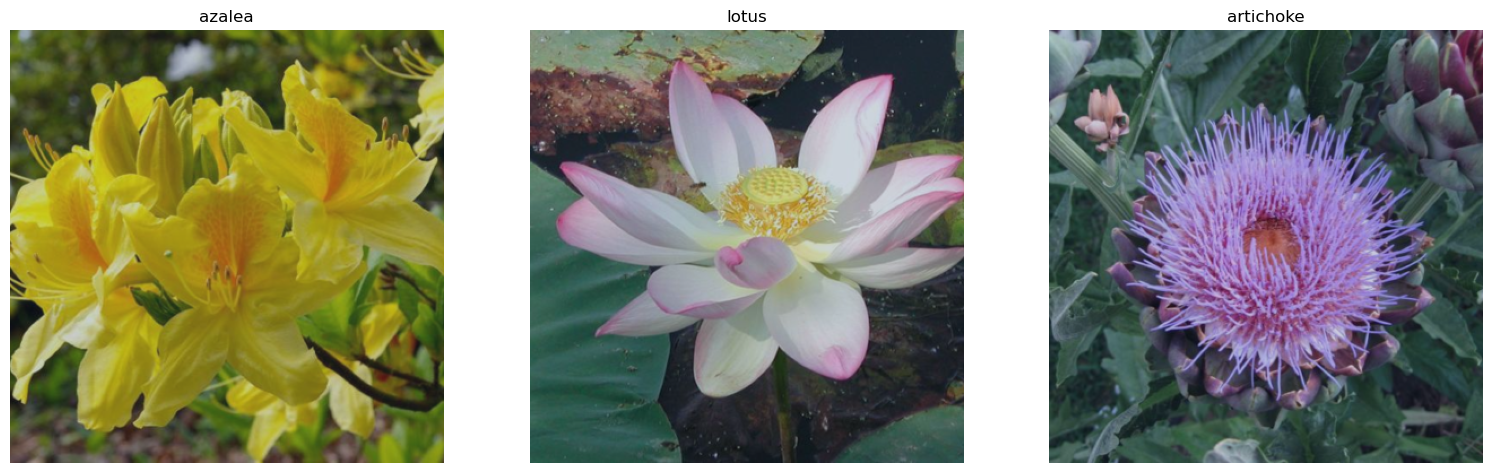

In [23]:
# visualize a batch of train data loader
images, labels = next(iter(train_dataloader))
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(19, 6))
rows, cols = 1, 3
for i in range(0, rows * cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image_ = np.transpose(images[i], (1, 2, 0)) 
    image_ = image_*[0.18]+[0.4] # unnormalize 
    plt.imshow(image_)
    plt.title(classes_name[class_names[labels[i].item()]])
    plt.axis(False);

### Train model

In [24]:
class EarlyStopping:
  def __init__(self, patience=7, verbose=False, delta=0.001):

    self.patience = patience
    self.verbose = verbose
    self.delta = delta
    self.best_score = None
    self.early_stop = False

  def __call__(self, val_loss):

    if self.best_score is None:
      self.best_score = val_loss
    elif (self.best_score - val_loss) < self.delta:
      self.patience -= 1
      if self.verbose and self.patience > 0:
        print(f'Loss validation not improved enough for {self.patience} epochs yet.  Waiting...')
    else:
      self.best_score = val_loss
      self.patience = self.patience  # reset patience if validation loss improves

    if self.patience <= 0:
      if self.verbose:
        print('Early stopping triggered.')
      self.early_stop = True

In [25]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel')
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
early_stopping = EarlyStopping(patience=5, verbose=True)

In [26]:
# Set the manual seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)

from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d%H%M')
model_name_saved = f'{timestamp}_{model.__class__.__name__}'
print(model_name_saved)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
print(datetime.now())

# Setup training and save the results
results = engine_classification.run_model(model=model,
                       train_dataloader=train_dataloader,
                       validation_dataloader=val_dataloader, 
                       optimizer=optimizer,
                       scheduler=scheduler,
                       early_stopping=early_stopping,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device,
                       model_name=model_name_saved)

# End the timer
end_time = timer()
print(f"[INFO] Total training time: {((end_time-start_time)/60):.3f} minutes")

202403070138_EfficientNet
2024-03-07 01:38:59.439563


  0%|          | 0/10 [00:00<?, ?it/s]

Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 1 | lr: 0.001 | train_loss: 2.7646 | train_acc: 0.1857 | validation_loss: 2.6874 | validation_acc: 0.2581
model saved at epoch: 1


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 2 | lr: 0.001 | train_loss: 2.1897 | train_acc: 0.3243 | validation_loss: 1.4335 | validation_acc: 0.5108
model saved at epoch: 2


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 3 | lr: 0.001 | train_loss: 1.5724 | train_acc: 0.5132 | validation_loss: 1.8736 | validation_acc: 0.6344
Loss validation not improved enough for 4 epochs yet.  Waiting...


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 4 | lr: 0.001 | train_loss: 1.1173 | train_acc: 0.6460 | validation_loss: 0.6639 | validation_acc: 0.8172
model saved at epoch: 4


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 5 | lr: 0.001 | train_loss: 0.9762 | train_acc: 0.7021 | validation_loss: 2.9873 | validation_acc: 0.6667
Loss validation not improved enough for 3 epochs yet.  Waiting...


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 6 | lr: 0.001 | train_loss: 0.7619 | train_acc: 0.7608 | validation_loss: 0.9615 | validation_acc: 0.8441
Loss validation not improved enough for 2 epochs yet.  Waiting...


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 7 | lr: 0.001 | train_loss: 0.5536 | train_acc: 0.8337 | validation_loss: 0.5041 | validation_acc: 0.8656
model saved at epoch: 7


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 8 | lr: 0.001 | train_loss: 0.4746 | train_acc: 0.8582 | validation_loss: 0.7687 | validation_acc: 0.8172
Loss validation not improved enough for 1 epochs yet.  Waiting...


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 9 | lr: 0.001 | train_loss: 0.4527 | train_acc: 0.8582 | validation_loss: 0.7156 | validation_acc: 0.8387
Early stopping triggered.
early stopping at epoch: 8
[INFO] Total training time: 52.787 minutes


In [27]:
def plot_loss_curves(results):   
    loss = results["train_loss"]
    val_loss = results["validation_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["validation_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

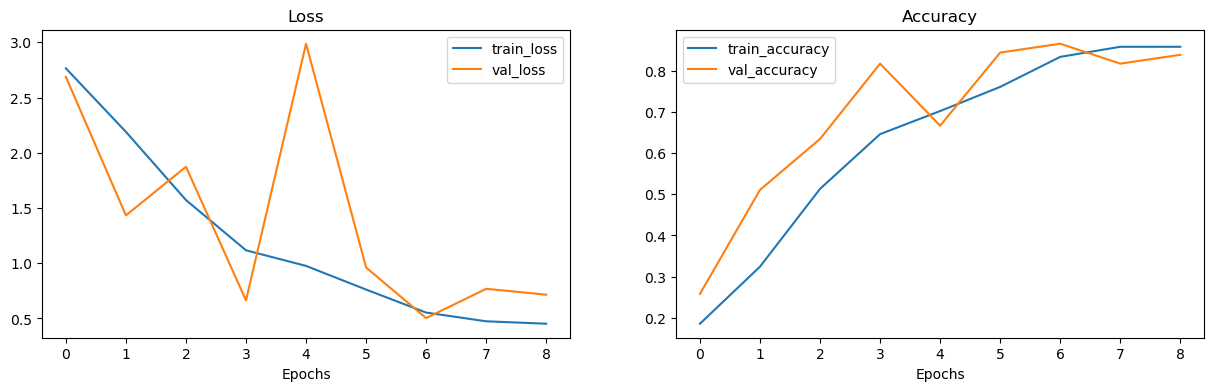

In [28]:
# Plot the loss curves of our model
plot_loss_curves(results)

In [29]:
#%load_ext tensorboard # line magic to load TensorBoard
#%tensorboard --logdir runs # run TensorBoard session with the "runs/" directory

# Inference / Load saved model

In [30]:
import torch
import torchvision
import json
import matplotlib.pyplot as plt
import os
import random

from PIL import Image
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
# load model using full model saved
# load weights for getting transform
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
transform = weights.transforms()
model_load = torch.load('models/202403070138_EfficientNet_full.pth') 
#model_load

In [33]:
# Opening file trained classes
f = open('classes_trained')
# json to dictionary
classes_names_trained = json.load(f)
# Closing file
f.close()
print(f'trained classes names: {classes_name}')

trained classes names: {'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved p

In [34]:
# Opening JSON file
f = open('dataset/cat_to_name.json')
# json to dictionary
classes_json = json.load(f)
# Closing file
f.close()

In [35]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    classes_names_trained,
    classes_json,
    transform,
    device):
       
    image = Image.open(image_path) # Load in image 
    
    image = transform(image).unsqueeze(0).to(device) # Transform the image, add batch dimension and put image on target device
    
    model.to(device) # model on the target device     
    model.eval() # Turn on model evaluation mode and inference mode
    
    pred_dict = {}
    
    with torch.no_grad():     
        pred_logit = model(image) # perform inference on target sample 
        pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
        pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
        #pred_class = classes_name[str(pred_label.cpu().item())] # 

        # put in the dictionary
        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_label"] = pred_label

        pred_dictionary.append(pred_dict)
        
    # Plot the image
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy()*[0.18]+[0.4]) # unnormalize  
    
    if classes_names_trained:
        title = f"{classes_json[classes_names_trained[pred_label.cpu().item()]]} | Prob: {pred_prob.max().cpu():.4f}"
    else:
        title = f"{pred_label.cpu().item()} | Prob: {pred_prob.max().cpu():.4f}"
        
    plt.title(title)
    plt.axis(False)

    return pred_dictionary

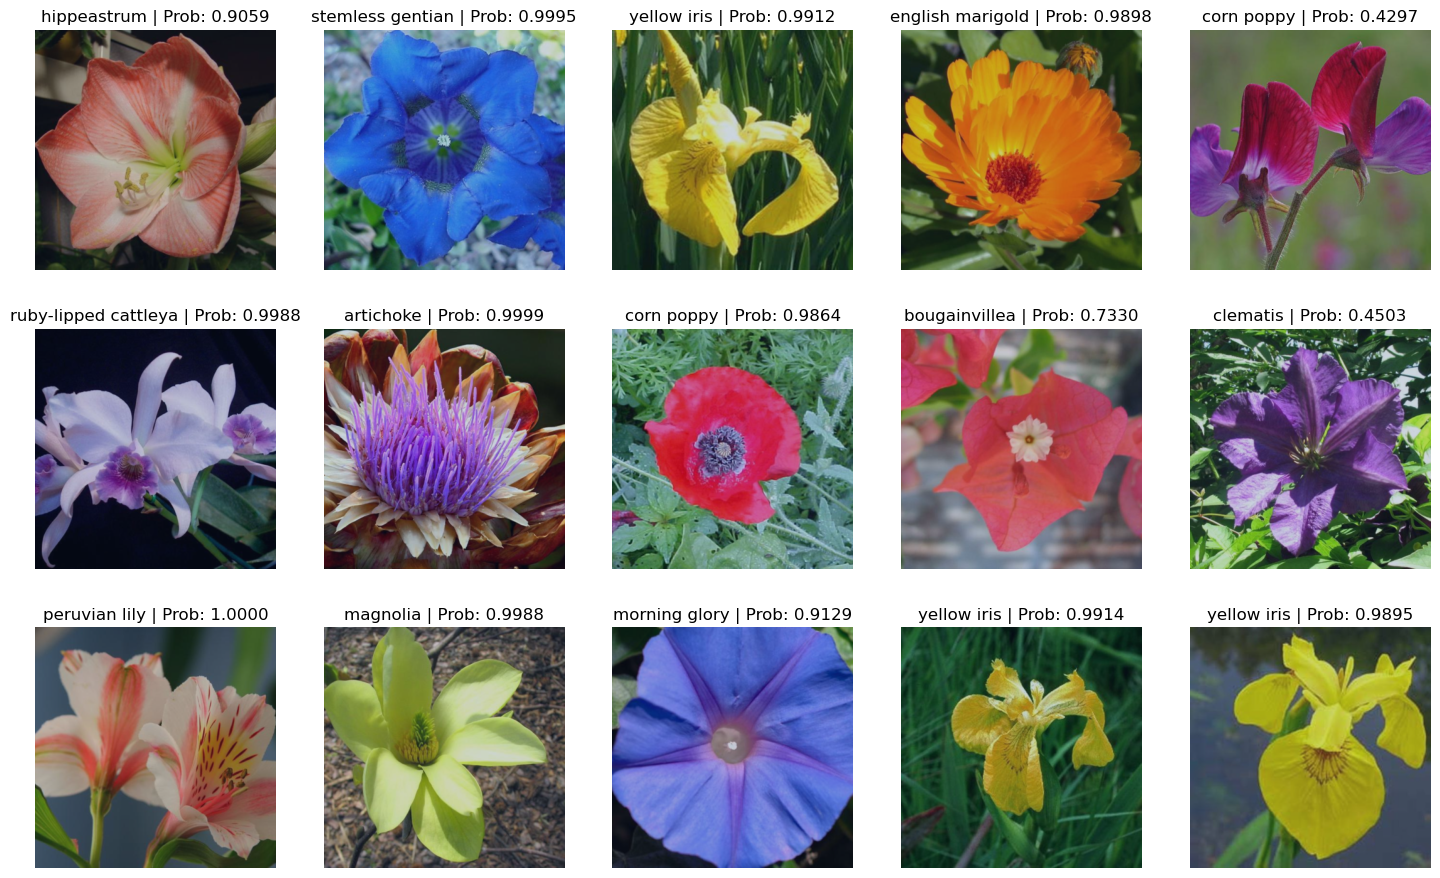

In [36]:
# Set the manual seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)

root_path = Path(os.getcwd())
# Get a list of all test image filepaths
test_dir = root_path / "dataset_subset" / "val"
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

pred_dictionary=[]

# Randomly select a test image path
img_paths = random.sample(test_data_paths, k=15)

fig = plt.figure(figsize=(18, 11))
rows, cols = 3, 5
for i in range(0, rows * cols):
    ax = fig.add_subplot(rows, cols, i+1)
    img = img_paths[i]
    pred_dictionary = pred_and_plot_image(model_load, img, classes_names_trained, classes_json, transform, device)
    